Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 3  
Due: May 27, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import dask.array as da
import dask
import xarray as xr

# import pickle
# import seaborn as sns

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
wd="/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw3"
data_dir=wd+"/data/"
model_dir=wd+"/models/"

cropped_dir=data_dir + "yale_cropped/"
uncropped_dir=data_dir + "yale_uncropped/"

### Functions

In [4]:
import glob
def fn_list(thisDir, fn_pattern):
    '''
    Function that returns a sorted list of filenames 
    based on a regex pattern in specified directory
    '''
    fns=[]
    for f in glob.glob(thisDir + "/" + fn_pattern): fns.append(f)
    fns.sort()
    return fns

In [5]:
# def densify(t, y, dt):
#     from scipy.interpolate import interp1d
#     f = interp1d(t, y, kind='cubic')
#     tnew = np.arange(t[0], t[-1], dt)
#     ynew = f(tnew)
#     return(tnew, ynew)

# def DMD(X, Xprime, r, dt):
#     '''Dynamic Mode Decomposition Function from book'''
#     U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
#     Ur = U[:,:r]
#     Sigmar = np.diag(Sigma[:r])
#     VTr = VT[:r,:]
#     Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
#     Lambda, W = np.linalg.eig(Atilde) # Step 3
#     Lambda = np.diag(Lambda)
    
#     Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
#     alpha1 = Sigmar @ VTr[:,0]
#     b = np.linalg.solve(W @ Lambda,alpha1)
#     Omega = np.log(np.diag(Lambda))/dt
#     return Phi, Omega, b, Lambda

# def forecast(Phi, Omega, t, b, r, dt):
#     u_modes = np.zeros((r, t))
#     time_vector = dt*np.arange(-1, t-1)
#     for i in np.arange(0, t):
#         u_modes[:, i]=b * np.exp(Omega * time_vector[i])
#     Xdmd = Phi @ u_modes
#     print(t, u_modes.shape, time_vector.shape, Xdmd.shape)
#     return(Xdmd)

#### Figure formatting

In [6]:
y_position=0.92
fontsize=16
weight="bold"

### Load data

In [7]:
cropped_fns = fn_list(data_dir+"yale_cropped/yale*", "*")
uncropped_fns = fn_list(data_dir+"yale_uncropped", "*")

# Start with cropped images 

In [10]:
%%time
# # Template and load all into memory
# fn=cropped_fns[0]
# f=xr.open_rasterio(fn)

# arrays=[da.from_array(xr.open_rasterio(fn).data, chunks=f.shape) for fn in cropped_fns] 
# x=da.concatenate(arrays, axis=0)

CPU times: user 3.45 s, sys: 352 ms, total: 3.8 s
Wall time: 4.31 s


#### With delayed 

In [8]:
%%time
xr_rio = dask.delayed(xr.open_rasterio, pure=True)

# Delayed
lazy=[dask.delayed(xr_rio)(fn) for fn in cropped_fns] 

# Get template
f=lazy[0].compute()

# Create dask array for image cube
arrays=[da.from_delayed(x, 
                      shape=f.shape, 
                      dtype=f.dtype) 
      for x in lazy]
stack = da.concatenate(arrays, axis=0)

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


CPU times: user 361 ms, sys: 15.2 ms, total: 376 ms
Wall time: 375 ms


In [9]:
stack

dask.array<concatenate, shape=(2432, 192, 168), dtype=uint8, chunksize=(1, 192, 168)>

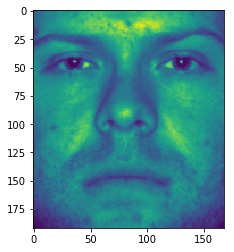

In [10]:
plt.imshow(stack[0])

## Question 1. Do an SVD analysis of the images

#### Reshape stack with images as column vectors (1D) and each image as a new column

In [58]:
# Create dask array for SVD analysis
arrays=[da.from_delayed(x, 
                      shape=np.ravel(x).shape, 
                      dtype=f.dtype) 
      for x in lazy]
# rav_stack=[x.ravel() for x in arrays]
rav_stack = da.stack(arrays, axis=1)

In [60]:
arrays[0]

dask.array<from-value, shape=(1,), dtype=uint8, chunksize=(1,)>

In [16]:
import seaborn as sns

In [30]:
u, s, v = np.linalg.svd(np.array(rav_stack))

# var_explained = np.round(s**2/np.sum(s**2), decimals=3)
# print(len(var_explained[var_explained>0]))

# fig, ax = plt.subplots(figsize=(14, 4))
# ax.plot(var_explained)
# ax.plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");
# ax.set_ylabel('% Var Explained', fontsize=16)
# sns.barplot(x=list(range(1,len(var_explained)+1)),
#             y=var_explained, color="limegreen", ec='k', ax=ax[0])

TypeError: invalid indexer array, does not have integer dtype: array(None, dtype=object)

---

In [15]:
X=df.Hare.values
Y=df.Lynx.values

from scipy.linalg import hankel
# Construct Hankel matrix
H_X = hankel(X)
H_Y = hankel(Y)

print(H_X.shape, H_Y.shape)

(30, 30) (30, 30)


21
20


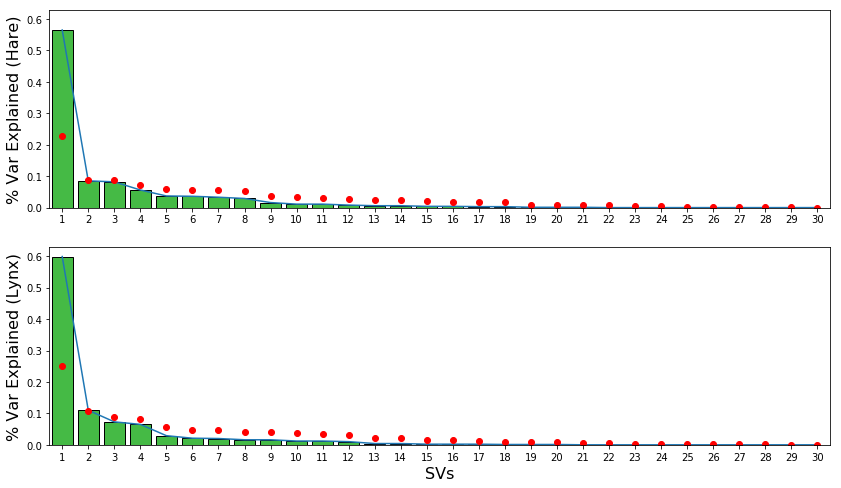

In [16]:
# Take SVD of H_X
u, s, v = np.linalg.svd(H_X)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharey=True)
ax[0].plot(var_explained)
ax[0].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");
ax[0].set_ylabel('% Var Explained (Hare)', fontsize=16)
ax[1].set_ylabel('% Var Explained (Lynx)', fontsize=16)
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax[0])

# Take SVD of H_Y
u, s, v = np.linalg.svd(H_Y)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))
ax[1].plot(var_explained)
ax[1].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");

sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax[1])
plt.xlabel('SVs', fontsize=16);

SVD shows 21 and 20 potential variables involved in the system for the hares and lynx, respectively

This suggests that there are quite a few latent variables not being measured in this dynamic system as we are only measuring 2 variables (lynx and hare)

#### Run DMD on Hankel matrices, interpolating to same degree as DMD models

In [17]:
make_it_dense = 5

if make_it_dense is not None:
    # With interpolation
    t = df.Year.values
    dt = (t[1] - t[0])/make_it_dense

    # Interpolate for more points
    years, dense_hare = densify(t, df.Hare.values, dt)
    years, dense_lynx = densify(t, df.Lynx.values, dt)

    H_hare = hankel(dense_hare)
    H_lynx = hankel(dense_lynx)
    
else:
    # Without interpolation
    H_hare = hankel(df.Hare.values)
    H_lynx = hankel(df.Lynx.values)
    
    t = df.Year.values
    dt = (t[1] - t[0])
    
print(dt, H_hare.shape)

0.4 (145, 145)


In [18]:
H_matrices = [H_hare, H_lynx]
X_matrices = []
Xprime_matrices = []

for H in H_matrices:    
    X=H[1:, :]
    Xprime=H[:-1, :]

    # Transpose matrices --> two state variables, want observations on other dimension?
    X=X.T
    Xprime=Xprime.T

    print(X.shape, Xprime.shape)
    
    X_matrices.append(X)
    Xprime_matrices.append(Xprime)


(145, 144) (145, 144)
(145, 144) (145, 144)


In [19]:
r=21

Phis =[]
Omegas = []
bs = []
Lambdas = []

for X, Xprime in zip(X_matrices, Xprime_matrices):
    Phi, Omega, b, Lambda = DMD(X, Xprime, r, dt)
    print(" Phi : Omega : b ", )
    print(Phi.shape, Omega.shape, b.shape)    

    Phis.append(Phi)
    Omegas.append(Omega)
    bs.append(b)
    Lambdas.append(Lambda)

 Phi : Omega : b 
(145, 21) (21,) (21,)
 Phi : Omega : b 
(145, 21) (21,) (21,)


#### DMD reconstruction using Hankel matrices

In [20]:
Xdmds = []
t = X.shape[1]

for Phi, Omega, b in zip(Phis, Omegas, bs):
    Xdmd = forecast(Phi, Omega, t, b, r, dt)
    Xdmds.append(Xdmd)

print(t, r, dt)

144 (21, 144) (144,) (145, 144)
144 (21, 144) (144,) (145, 144)
144 21 0.4


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


#### Plot DMD reconstruction

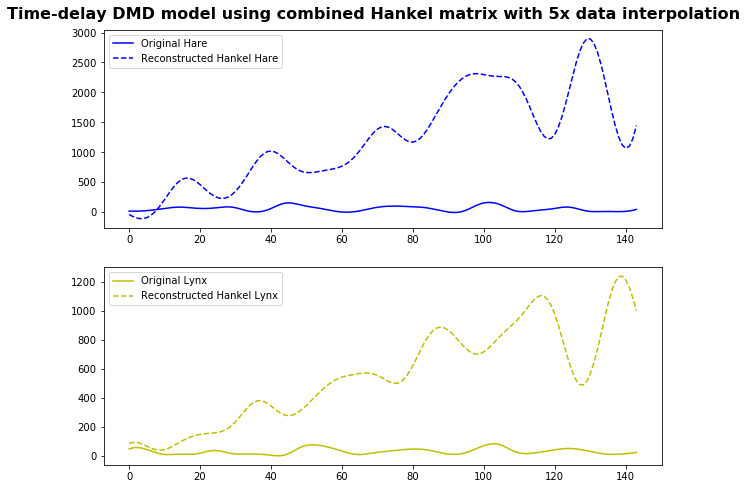

In [21]:
labels=["Hare", "Lynx"]
style_og=["b", "y"]
style_recon=["b--", "y--"]

fig, ax = plt.subplots(2, 1, figsize=(10,8))

for i in range(0, len(labels)):
    ax[i].plot(X_matrices[i].T[:, 0], style_og[i], label=str("Original " + labels[i]))
    ax[i].plot(Xdmds[i].T[:, 0], style_recon[i], label="Reconstructed Hankel " + labels[i])
    ax[i].legend()
    
plt.suptitle("Time-delay DMD model using combined Hankel matrix with 5x data interpolation", 
             y=y_position, fontsize=fontsize, weight=weight);

### Forecast 

In [22]:
t_forecast = int(t*1.5)

Xdmds_forecast = []

for Phi, Omega, b in zip(Phis, Omegas, bs):
    Xdmd = forecast(Phi, Omega, t_forecast, b, r, dt)
    Xdmds_forecast.append(Xdmd)

# Xdmd = forecast(Phi, Omega, t_forecast, b, r, dt)

216 (21, 216) (216,) (145, 216)
216 (21, 216) (216,) (145, 216)


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


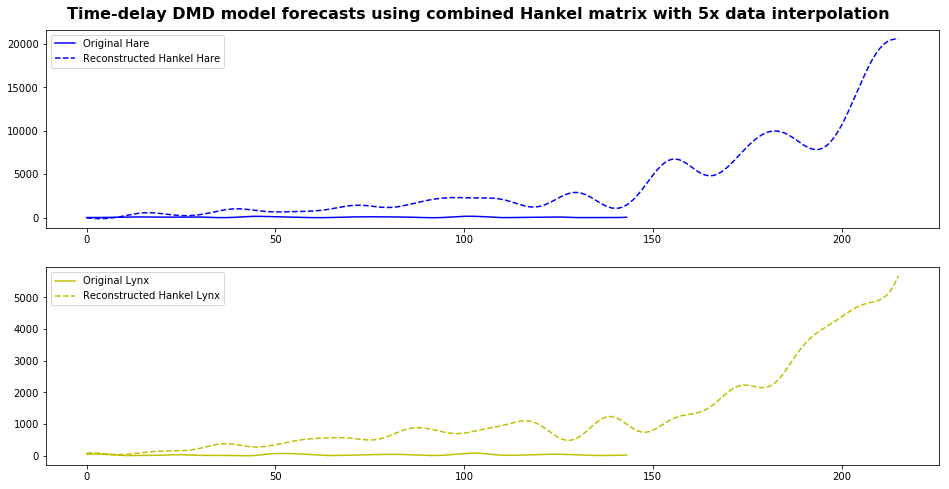

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))

for i in range(0, len(labels)):
    ax[i].plot(X_matrices[i].T[:, 0], style_og[i], label=str("Original " + labels[i]))
    ax[i].plot(Xdmds_forecast[i].T[:, 0], style_recon[i], label="Reconstructed Hankel " + labels[i])
    ax[i].legend()
    
plt.suptitle("Time-delay DMD model forecasts using combined Hankel matrix with 5x data interpolation", 
             y=y_position, fontsize=fontsize, weight=weight);    

#### Save DMD with Hankel models with pickle (not the forecast DMDs)

In [24]:
DMD_H_hare = [Phis[0], bs[0], Omegas[0], r]
DMD_H_lynx = [Phis[1], bs[1], Omegas[1], r]

DMD_hare_fn = model_dir + str("DMD_H_hare" + "_" + str(make_it_dense) + "pts.pkl")
DMD_lynx_fn = model_dir + str("DMD_H_lynx" + "_" + str(make_it_dense) + "pts.pkl")

DMD_components = [DMD_H_hare, DMD_H_lynx]
DMD_fns = [DMD_hare_fn, DMD_lynx_fn]

for fn, component in zip(DMD_fns, DMD_components):    
    if not os.path.exists(fn):
        with open(fn, "wb") as file:
            pickle.dump(component, file)   
    else:
        print(fn, "exists")

/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/DMD_H_hare_5pts.pkl exists
/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/DMD_H_lynx_5pts.pkl exists
